## Frontotemporal Disease ( Demência)

## Carregar Dados Pre-prontos

In [ ]:
import os
import numpy as np
import tensorflow as tf

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import sys

from utility_funcs import evaluate_thresholds

from tensorflow.keras.layers import Input
sns.set_context('poster')

In [ ]:
base_path = r'C:\Users\decmg\OneDrive\Documentos\Material Disciplinas\MO444\data\processed'
x_train = np.load(os.path.join(base_path, 'x_train_bin_DM.npy'))
y_train = np.load(os.path.join(base_path, 'y_train_bin_DM.npy'))
x_val = np.load(os.path.join(base_path, 'x_val_bin_DM.npy'))
y_val = np.load(os.path.join(base_path, 'y_val_bin_DM.npy'))
x_test = np.load(os.path.join(base_path, 'x_test_bin_DM.npy'))
y_test = np.load(os.path.join(base_path, 'y_test_bin_DM.npy'))

In [ ]:
np_train = (x_train, y_train)
np_val = (x_val, y_val)
np_test = (x_test, y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
x_train_reshaped = x_train.reshape(-1, x_train.shape[-1])
x_val_reshaped = x_val.reshape(-1, x_val.shape[-1])
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])

In [ ]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_val_scaled = scaler.transform(x_val_reshaped)
x_test_scaled = scaler.transform(x_test_reshaped)

x_train_scaled = x_train_scaled.reshape(x_train.shape)
x_val_scaled = x_val_scaled.reshape(x_val.shape)
x_test_scaled = x_test_scaled.reshape(x_test.shape)

## Otimização com Optuna

In [8]:
n_timesteps = 256  # Número de passos de tempo
n_features = 19    # Número de características (features)

In [ ]:
import optuna
from utility_funcs import objective

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, x_train_scaled, y_train, x_val_scaled, y_val, n_timesteps, n_features), n_trials=20, show_progress_bar=True)

In [ ]:
best_params = {'filters_1': 64, 
               'filters_2': 32, 
               'lstm_units': 100, 
               'dense_units': 16, 
               'dropout_rate': 0.50400637008449826, 
               'learning_rate': 0.00016004991224509236, 
               'l2_reg': 0.0032567578808696807}

## Treinamento

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
np.random.seed(42)


model = Sequential([
    Input(shape=(n_timesteps, n_features)),
    Conv1D(filters=best_params['filters_1'], kernel_size=3, activation='relu',
           kernel_regularizer=l2(best_params['l2_reg'])),
    MaxPooling1D(pool_size=2),
    Dropout(best_params['dropout_rate']),
    
    Conv1D(filters=best_params['filters_2'], kernel_size=3, activation='relu',
           kernel_regularizer=l2(best_params['l2_reg'])),
    MaxPooling1D(pool_size=2),
    Dropout(best_params['dropout_rate']),
    
    LSTM(best_params['lstm_units'], activation='tanh', return_sequences=False,
         kernel_regularizer=l2(best_params['l2_reg'])),
    Dropout(best_params['dropout_rate']),
    
    Dense(best_params['dense_units'], activation='relu', kernel_regularizer=l2(best_params['l2_reg'])),
    Dropout(best_params['dropout_rate'] / 2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, mode='min')
]

history = model.fit(
    x_train_scaled, y_train,
    validation_data=(x_val_scaled, y_val),
    epochs=10,  
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.5905 - auc: 0.4979 - loss: 1.1724 - precision: 0.3816 - recall: 0.0702 - val_accuracy: 0.5297 - val_auc: 0.5188 - val_loss: 1.0897 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.6069 - auc: 0.5113 - loss: 1.0445 - precision: 0.3384 - recall: 0.0043 - val_accuracy: 0.5297 - val_auc: 0.5520 - val_loss: 0.9907 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.6085 - auc: 0.5397 - loss: 0.9491 - precision: 0.4163 - recall: 0.0015 - val_accuracy: 0.5304 - val_auc: 0.6087 - val_loss: 0.9214 - val_precision: 1.0000 - val_recall: 0.0014
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.6311 - auc: 0.6885 - loss: 0.8445 - precision: 0.6158 - recall: 0.1214 - val_accuracy: 0.6220 - val_auc: 0.6705 - val_loss: 0.8911 - val_precision: 0.5831 - val_recall: 0.6881
Epoch 5/

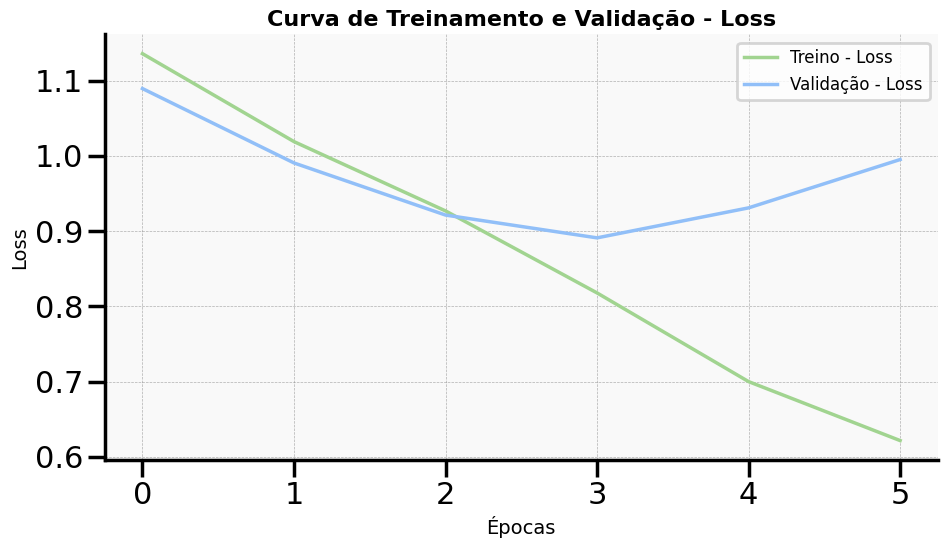

282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Métricas no Conjunto de Validação:
              precision    recall  f1-score   support

           0       0.65      0.42      0.51      4778
           1       0.53      0.75      0.62      4242

    accuracy                           0.58      9020
   macro avg       0.59      0.59      0.57      9020
weighted avg       0.60      0.58      0.57      9020

AUC no Conjunto de Validação: 0.6705715375101464


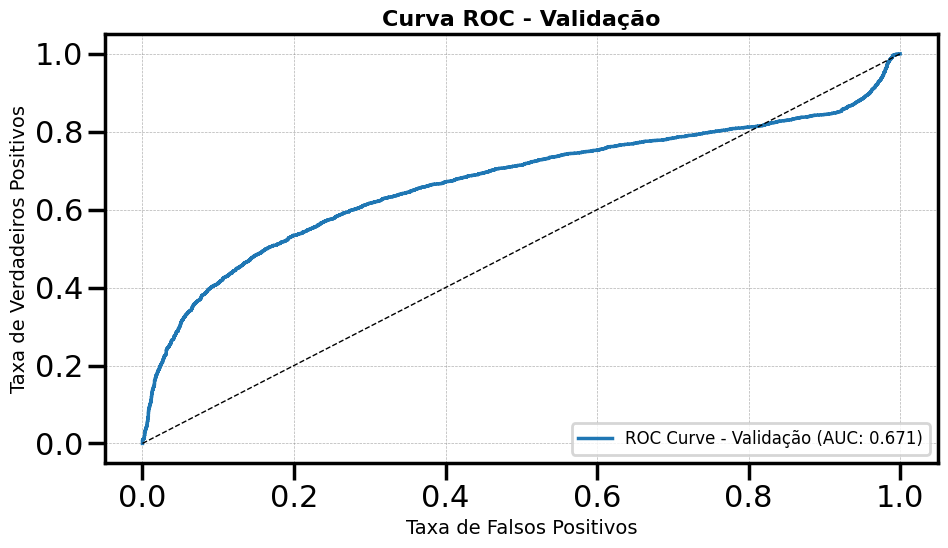

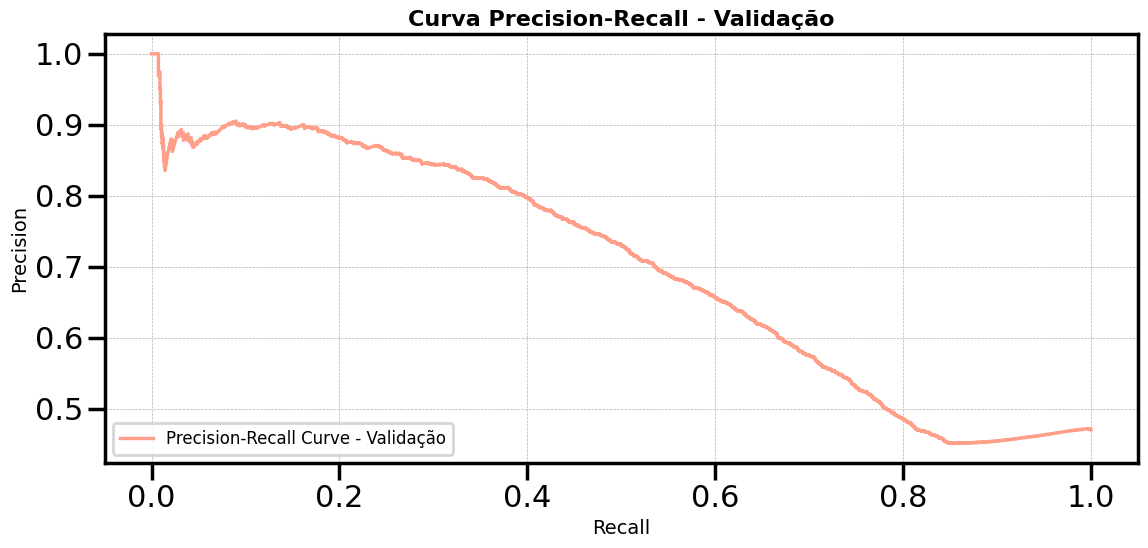

In [15]:
from utility_funcs import plot_training_curves, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score

plot_training_curves(history)

y_val_pred_probs = model.predict(x_val_scaled).ravel()
y_val_pred = (y_val_pred_probs >= 0.4).astype(int)

print("\nMétricas no Conjunto de Validação:")
print(classification_report(y_val, y_val_pred))
print("AUC no Conjunto de Validação:", roc_auc_score(y_val, y_val_pred_probs))

plot_roc_curve(y_val, y_val_pred_probs)
plot_precision_recall_curve(y_val, y_val_pred_probs)

Text(0.5, 1.0, 'Matriz de Confusão para FTD')

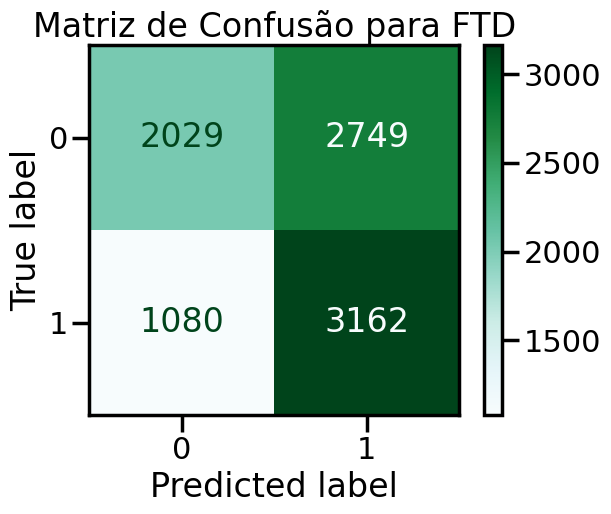

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.BuGn)
plt.title("Matriz de Confusão para FTD")

In [ ]:
thresholds = np.arange(.2,.7,.025)

metrics_table_val = evaluate_thresholds(y_val, y_val_pred_probs, thresholds)
print("Métricas no Conjunto de Validação:")
print(metrics_table_val)

Métricas no Conjunto de Validação:
    Threshold  Accuracy  Precision    Recall  F1-Score       AUC
0       0.200  0.459978   0.459341  0.837577  0.593304  0.670572
1       0.225  0.475166   0.467112  0.823668  0.596144  0.670572
2       0.250  0.489135   0.474752  0.811174  0.598956  0.670572
3       0.275  0.505211   0.484257  0.801273  0.603676  0.670572
4       0.300  0.519512   0.493231  0.790193  0.607356  0.670572
5       0.325  0.532373   0.501823  0.778642  0.610310  0.670572
6       0.350  0.548448   0.513288  0.769448  0.615791  0.670572
7       0.375  0.563193   0.524681  0.756719  0.619691  0.670572
8       0.400  0.575499   0.534935  0.745403  0.622870  0.670572
9       0.425  0.590022   0.547955  0.732673  0.626992  0.670572
10      0.450  0.599667   0.557879  0.716879  0.627463  0.670572
11      0.475  0.613304   0.572139  0.704856  0.631601  0.670572
12      0.500  0.621951   0.583100  0.688119  0.631272  0.670572
13      0.525  0.641907   0.610432  0.659359  0.633953 

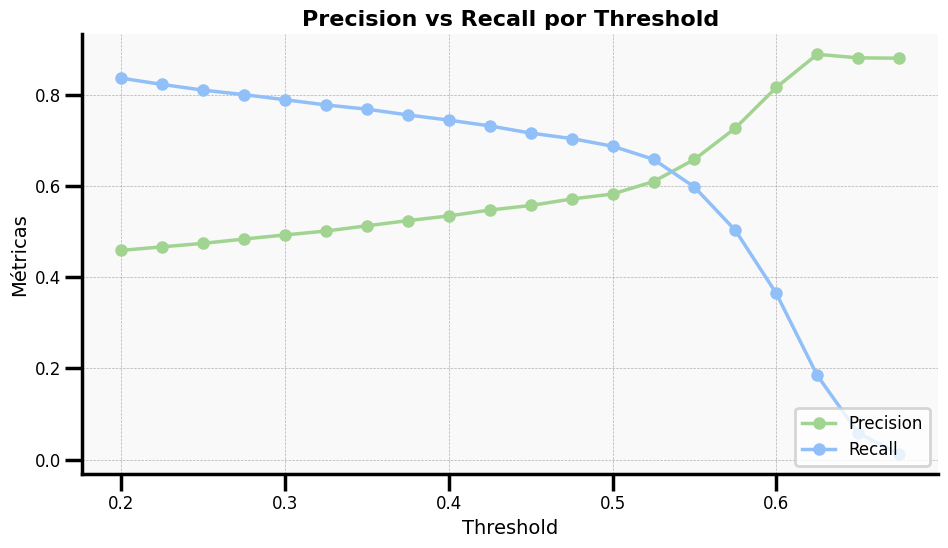

In [ ]:
from utility_funcs import plot_precision_recall_by_threshold

plot_precision_recall_by_threshold(metrics_table_val)

In [ ]:
y_test_pred_probs = model.predict(x_test_scaled).ravel()
y_test_pred = (y_test_pred_probs >= 0.4).astype(int)

print("\nMétricas no Conjunto de Teste:")
print(classification_report(y_test, y_test_pred))
print("AUC no Conjunto de Teste:", roc_auc_score(y_test, y_test_pred_probs))

255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Métricas no Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.70      0.43      0.53      4984
           1       0.44      0.71      0.55      3176

    accuracy                           0.54      8160
   macro avg       0.57      0.57      0.54      8160
weighted avg       0.60      0.54      0.54      8160

AUC no Conjunto de Teste: 0.6206463959228726
